In [1]:
import tensorflow as tf
from tensorflow.keras.applications import VGG16
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
import numpy as np

# Load the VGG16 model without the top (classification) layers
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(150, 150, 3))

# Freeze all layers in the base model
for layer in base_model.layers:
    layer.trainable = False

# Get the last but one layer of the base model
last_but_one_layer = base_model.get_layer('block5_conv3').output

# Apply GlobalAveragePooling2D to the last but one layer
gap_layer = tf.keras.layers.GlobalAveragePooling2D()(last_but_one_layer)

# Create the final model
model = Model(inputs=base_model.input, outputs=gap_layer)

# Data generator
datagen = ImageDataGenerator(rescale=1./255)
generator = datagen.flow_from_directory(
    "E:\College\SEMESTER 4\MACHINE LEARNING\Archive",  
    target_size=(150, 150),
    batch_size=32,
    class_mode=None,  
    shuffle=False)

# Predict features using the final model
features = model.predict(generator, steps=np.ceil(generator.samples/generator.batch_size))

# Get the labels
labels = generator.classes

# Save the extracted features and labels
np.save('extracted_features.npy', features)
np.save('labels.npy', labels)

# Load the saved features and labels
loaded_features = np.load('extracted_features.npy')
loaded_labels = np.load('labels.npy')

KeyboardInterrupt: 

In [2]:
import numpy as np
#features
loaded_features = np.load('extracted_features.npy')
print("Shape of loaded features:", loaded_features.shape)


Shape of loaded features: (42500, 512)


In [3]:
# Import necessary libraries
import numpy as np
from sklearn.decomposition import PCA

# Load the features and labels from saved numpy files
loaded_features = np.load('extracted_features.npy')
loaded_labels = np.load('labels.npy')

# Initialize a PCA model to reduce features to 5 dimensions
pca = PCA(n_components=5)
# Fit the PCA model on the loaded features and transform them
reduced_features = pca.fit_transform(loaded_features)

# Mapping from class indices to class names
class_indices_to_names = {
    0: 'Academic Art',
    1: 'Art Nouveau',
    2: 'Baroque',
    3: 'Expressionism',
    4: 'Japanese Art',
    5: 'Neoclassism',
    6: 'Primitivism',
    7: 'Realism',
    8: 'Renaissance',
    9: 'Rococo',
    10: 'Romanticism',
    11: 'Symbolism',
    12: 'Western Medieval'
}

# Initialize a dictionary to store original and reduced features for each class
features_by_class = {name: {'original': [], 'reduced': []} for name in class_indices_to_names.values()}

# Loop through each feature, its reduced form, and its label
for feature, reduced_feature, label in zip(loaded_features, reduced_features, loaded_labels):
    # Get the class name using the label
    class_name = class_indices_to_names[label]
    # Append the original and reduced features to their respective lists in the dictionary
    features_by_class[class_name]['original'].append(feature)
    features_by_class[class_name]['reduced'].append(reduced_feature)

# Loop through each class and its features
for class_name, features in features_by_class.items():
    # Print the class name and the number of feature vectors it has
    print(f"Class: {class_name}, Number of Feature Vectors: {len(features['original'])}")
    # Print the first original feature vector of the class
    print(f"First Original Feature Vector: {features['original'][0]}")
    # Print the first reduced feature vector of the class
    print(f"First Reduced Feature Vector: {features['reduced'][0]}\n")


Class: Academic Art, Number of Feature Vectors: 1305
First Original Feature Vector: [4.09548223e-01 0.00000000e+00 1.49333191e+00 4.09134664e-03
 5.40221557e-02 0.00000000e+00 3.73699367e-02 2.73657423e-02
 1.20384969e-01 3.72955725e-02 0.00000000e+00 1.51010528e-02
 4.36183989e-01 0.00000000e+00 0.00000000e+00 2.51756817e-01
 1.17118374e-01 3.66021276e-01 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 2.87087500e-01
 7.65858497e-03 0.00000000e+00 1.13861449e-01 1.05740137e-01
 4.72826585e-02 0.00000000e+00 1.94326997e-01 1.10883307e+00
 3.84337038e-01 3.95589918e-01 6.16018847e-02 0.00000000e+00
 2.02486008e-01 0.00000000e+00 4.78117988e-02 0.00000000e+00
 0.00000000e+00 0.00000000e+00 4.99723926e-02 0.00000000e+00
 1.53679401e-01 1.85743839e-01 1.65792882e-01 0.00000000e+00
 9.03542340e-03 9.84521508e-02 6.99632987e-02 4.80595324e-03
 2.71393526e-02 0.00000000e+00 6.74627628e-03 5.19975424e-01
 4.25865650e-01 9.91561562e-02 2.28063464e-02 1.32825240e-01
 

A1. Evaluate the intraclass spread and interclass distances between the classes in your dataset. If 
your data deals with multiple classes, you can take any two classes. 

In [4]:
# Import necessary libraries
import numpy as np
from numpy.linalg import norm

# Initialize a dictionary to store reduced features grouped by class
reduced_features_by_class = {}
# Loop through each reduced feature vector and its corresponding label
for feature, label in zip(reduced_features, loaded_labels):
    # Map the label to a class name
    class_name = class_indices_to_names[label]
    # If this class hasn't been seen before, initialize an empty list for it
    if class_name not in reduced_features_by_class:
        reduced_features_by_class[class_name] = []
    # Append the current feature vector to the list of reduced features for this class
    reduced_features_by_class[class_name].append(feature)

# Initialize dictionaries to store the centroids and spreads of each class
class_centroids = {}
class_spreads = {}
# Loop through each class and its list of reduced features
for class_name, features in reduced_features_by_class.items():
    # Convert the list of features for this class into a NumPy array for easier calculations
    features_np = np.array(features)
    # Calculate the centroid (mean vector) for this class
    class_centroids[class_name] = np.mean(features_np, axis=0)
    # Calculate the spread (standard deviation) for this class
    class_spreads[class_name] = np.std(features_np, axis=0)

# Loop through each class to print its centroid and spread
for class_name in class_centroids:
    print(f"Class: {class_name}")
    print(f"  Centroid (Mean): {class_centroids[class_name]}")
    print(f"  Spread (Standard Deviation): {class_spreads[class_name]}\n")

# Calculate the Euclidean distance between the centroids of 'Academic Art' and 'Art Nouveau'
distance = norm(class_centroids['Academic Art'] - class_centroids['Art Nouveau'])
# Print the calculated distance
print(f"Distance between centroids of 'Academic Art' and 'Art Nouveau': {distance}")


Class: Academic Art
  Centroid (Mean): [ 0.98799765  0.21702392  0.03271348 -0.15940762 -0.01617535]
  Spread (Standard Deviation): [1.1876979 0.8716941 0.7989296 0.6765042 0.6050353]

Class: Art Nouveau
  Centroid (Mean): [-0.34756145 -1.0726808  -0.12136702  0.00282281 -0.2816179 ]
  Spread (Standard Deviation): [1.0190514  1.1039321  0.72851765 0.7100176  0.74274886]

Class: Baroque
  Centroid (Mean): [ 0.2270585   0.50632495  0.17777728 -0.21125108 -0.01577356]
  Spread (Standard Deviation): [1.2869544  1.0075848  0.8454437  0.62638927 0.6111773 ]

Class: Expressionism
  Centroid (Mean): [ 0.5025539  -0.30199414 -0.24074598  0.27639496  0.0161777 ]
  Spread (Standard Deviation): [1.1249713  1.1438895  0.7551997  0.73996913 0.74636614]

Class: Japanese Art
  Centroid (Mean): [ 0.03833779 -0.8584718  -0.18879238  0.08304071 -0.4214718 ]
  Spread (Standard Deviation): [1.0461257 1.0016173 0.6973596 0.6576937 0.6681113]

Class: Neoclassism
  Centroid (Mean): [-0.3920311  -0.6542741   0

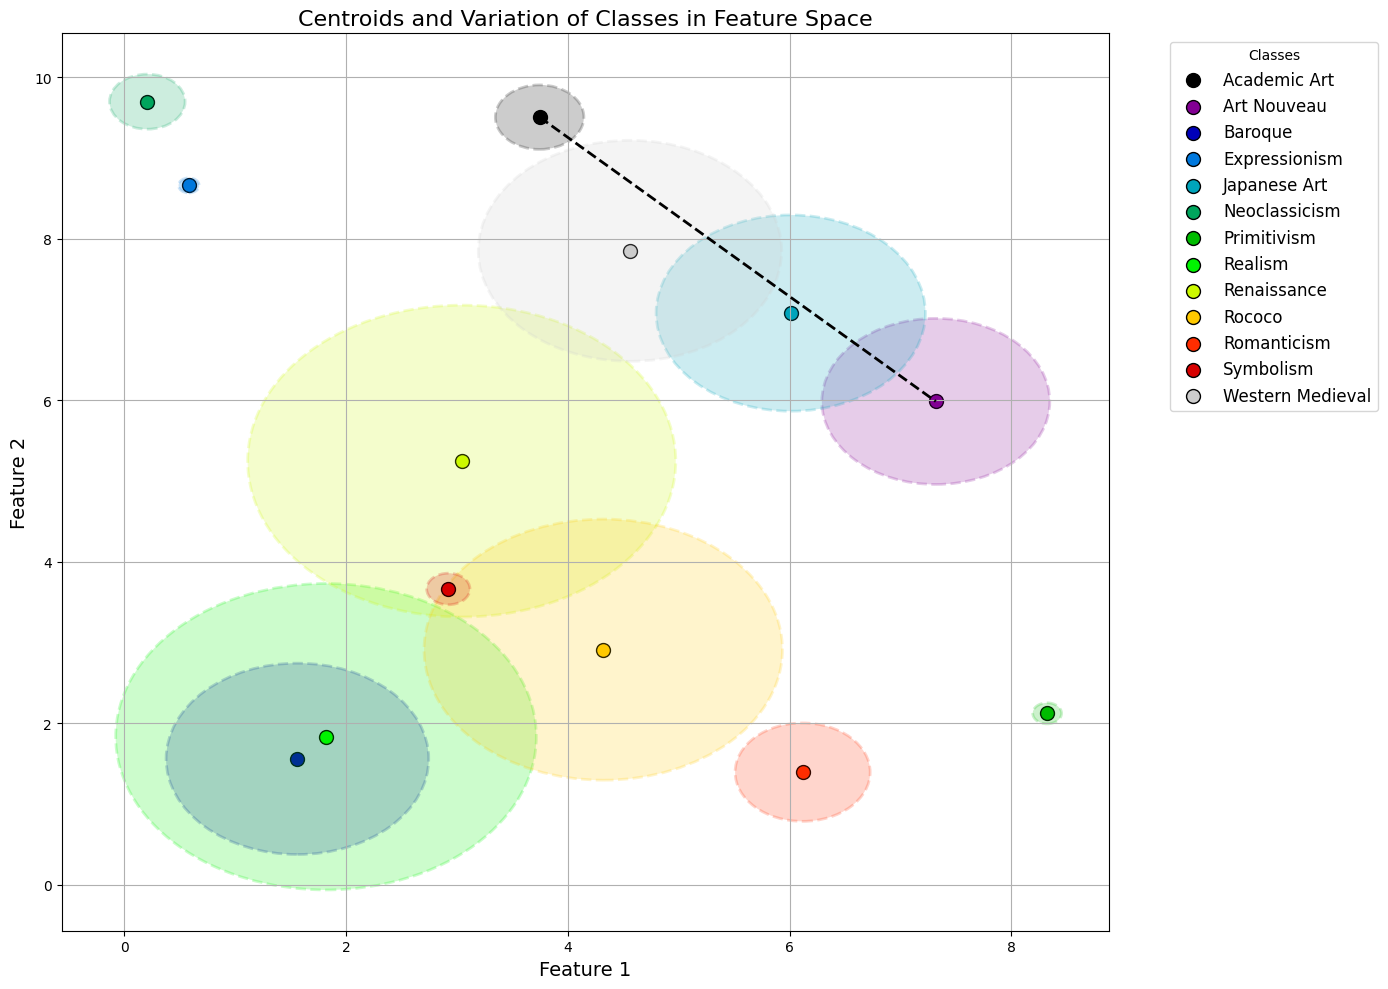

In [27]:
import matplotlib.pyplot as plt
from matplotlib.patches import Circle

plt.figure(figsize=(14, 10))

# Using the class_centroids and class_spreads computed from your dataset
class_names = list(class_centroids.keys())  # Extracting class names from the centroids dictionary

# Assigning a unique color to each class
colors = plt.cm.nipy_spectral(np.linspace(0, 1, len(class_names)))

for i, class_name in enumerate(class_names):
    centroid = class_centroids[class_name]
    spread = class_spreads[class_name]
    color = colors[i]
    plt.scatter(centroid[0], centroid[1], color=color, label=class_name, s=100, edgecolor='black')
    # Using spread to determine the radius of the circle. 
    circle = Circle(centroid, np.mean(spread), color=color, fill=True, linestyle='--', linewidth=2, alpha=0.2)
    plt.gca().add_patch(circle)

# draw a line between 'Academic Art' and 'Art Nouveau'
if 'Academic Art' in class_centroids and 'Art Nouveau' in class_centroids:
    plt.plot([class_centroids['Academic Art'][0], class_centroids['Art Nouveau'][0]],
             [class_centroids['Academic Art'][1], class_centroids['Art Nouveau'][1]],
             'k--', linewidth=2)

plt.title('Centroids and Variation of Classes in Feature Space', fontsize=16)
plt.xlabel('Feature 1', fontsize=14)
plt.ylabel('Feature 2', fontsize=14)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', title="Classes", fontsize=12)
plt.grid(True)
plt.tight_layout()
plt.show()


A2. Take any feature from your dataset. Observe the density pattern for that feature by plotting the 
histogram. Use buckets (data in ranges) for histogram generation and study. Calculate the mean and 
variance from the available data. 

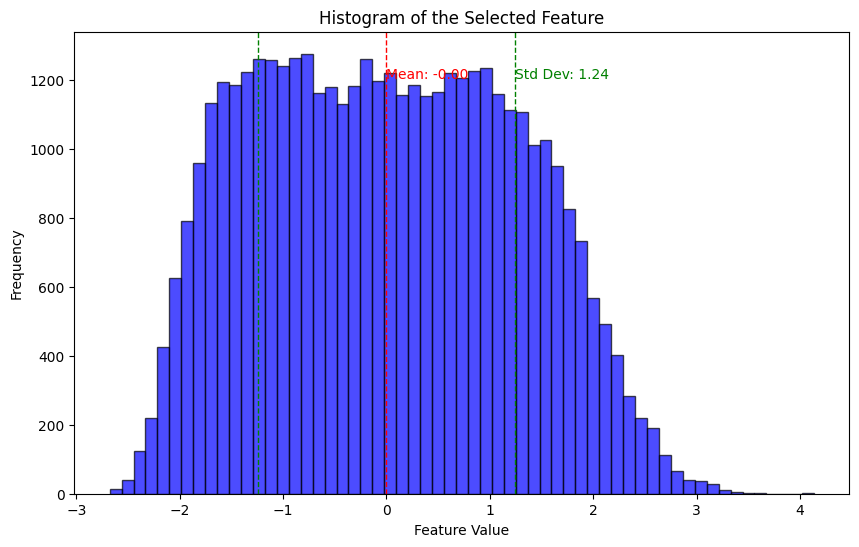

Mean of the selected feature: -1.2027516049784026e-06
Variance of the selected feature: 1.5431077480316162


In [6]:
# Import necessary libraries for plotting and numerical operations
import matplotlib.pyplot as plt
import numpy as np

# Select the first feature (column) from the reduced features set
selected_feature = reduced_features[:, 0]

# Generate histogram data for the selected feature, determining bin edges automatically
hist_data, bin_edges = np.histogram(selected_feature, bins='auto')

# Calculate the mean and variance of the selected feature
mean = np.mean(selected_feature)
variance = np.var(selected_feature)

# Create a figure for plotting with specified dimensions
plt.figure(figsize=(10, 6))

# Plot a histogram for the selected feature
# 'alpha' controls the transparency, 'color' sets the fill color, and 'edgecolor' sets the color of the bin edges
plt.hist(selected_feature, bins='auto', alpha=0.7, color='blue', edgecolor='black')

# Set the title of the histogram and labels for the x and y axes
plt.title('Histogram of the Selected Feature')
plt.xlabel('Feature Value')
plt.ylabel('Frequency')

# Add a vertical dashed line at the mean value of the selected feature, colored red
plt.axvline(mean, color='r', linestyle='dashed', linewidth=1)
plt.text(mean, plt.ylim()[1]*0.9, f'Mean: {mean:.2f}', color = 'red')

# Add vertical dashed lines for one standard deviation below and above the mean, colored green
plt.axvline(mean - np.sqrt(variance), color='g', linestyle='dashed', linewidth=1)
plt.axvline(mean + np.sqrt(variance), color='g', linestyle='dashed', linewidth=1)
plt.text(mean + np.sqrt(variance), plt.ylim()[1]*0.9, f'Std Dev: {np.sqrt(variance):.2f}', color = 'green')

plt.show()
print(f"Mean of the selected feature: {mean}")
print(f"Variance of the selected feature: {variance}")


A3. Take any two feature vectors from your dataset. Calculate the Minkwoski distance with r from 1 
to 10. Make a plot of the distance and observe the nature of this graph

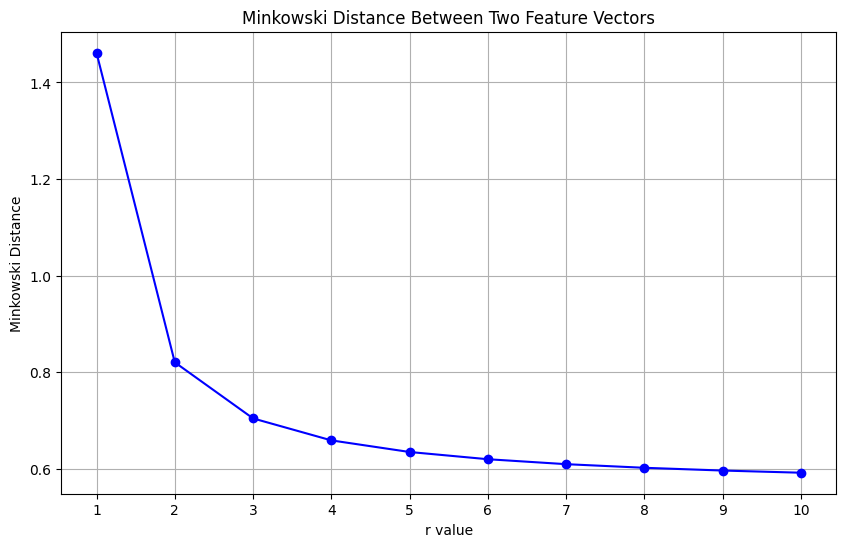

Minkowski distance for r = 1: 1.4616221170044787
Minkowski distance for r = 2: 0.8207711682520142
Minkowski distance for r = 3: 0.7046801622101914
Minkowski distance for r = 4: 0.65920340582391
Minkowski distance for r = 5: 0.6351436415371617
Minkowski distance for r = 6: 0.6201925097664138
Minkowski distance for r = 7: 0.6099501605540948
Minkowski distance for r = 8: 0.6024714395570326
Minkowski distance for r = 9: 0.5967629188471127
Minkowski distance for r = 10: 0.5922616129813852


In [7]:
# Import necessary libraries
import numpy as np
from scipy.spatial.distance import minkowski
import matplotlib.pyplot as plt
reduced_features = np.random.rand(10, 5)  
# Select the first two feature vectors for comparison
feature_vector_1 = reduced_features[0]
feature_vector_2 = reduced_features[1]

# Define a range of 'r' values from 1 to 10
r_values = range(1, 11)
# Calculate Minkowski distances between the two selected feature vectors for each 'r' value
distances = [minkowski(feature_vector_1, feature_vector_2, r) for r in r_values]

# Initialize a figure for plotting
plt.figure(figsize=(10, 6))
# Plot the distances against the 'r' values
plt.plot(r_values, distances, marker='o', linestyle='-', color='b')
# Set the title of the plot
plt.title('Minkowski Distance Between Two Feature Vectors')
plt.xlabel('r value')
plt.ylabel('Minkowski Distance')
plt.xticks(r_values)
plt.grid(True)
plt.show()
for r, distance in zip(r_values, distances):
    print(f"Minkowski distance for r = {r}: {distance}")


A4. Divide dataset in your project into two parts – train & test set. To accomplish this, use the train_test_split() function available in SciKit

In [8]:
# Import the function for splitting datasets from scikit-learn
from sklearn.model_selection import train_test_split
selected_class_indices = [0, 1]

# Filtering the features to include only those that correspond to the selected classes
selected_features = loaded_features[np.isin(loaded_labels, selected_class_indices)]

# filtering the labels to include only those that correspond to the selected classes
selected_labels = loaded_labels[np.isin(loaded_labels, selected_class_indices)]

# Converting the labels for a binary classification:
# If the label matches the first selected class index, it's converted to 0; otherwise, it's converted to 1.
selected_labels = np.array([0 if label == selected_class_indices[0] else 1 for label in selected_labels])

# Split the filtered features and labels into training and testing sets:
# 70% of the data is used for training (as indicated by test_size=0.3)
# 30% of the data is used for testing.
X_train, X_test, y_train, y_test = train_test_split(selected_features, selected_labels, test_size=0.3, random_state=42)

print("Training set size:", X_train.shape)
print("Testing set size:", X_test.shape)


Training set size: (3038, 512)
Testing set size: (1302, 512)


A5. Train a kNN classifier (k =3) using the training set obtained from above exercise.

In [18]:
import numpy as np
from sklearn.neighbors import KNeighborsClassifier

# Initializing the KNeighborsClassifier with n_neighbors=3 
neigh = KNeighborsClassifier(n_neighbors=3)

# Train the KNN model on the training dataset
neigh.fit(X_train, y_train)


KNeighborsClassifier(n_neighbors=3)

A6. Test the accuracy of the kNN using the test set obtained from above exercise. 

In [19]:
#calculating accuracy
accuracy = neigh.score(X_test, y_test)
print(accuracy)


0.880184331797235


A7. Use the predict() function to study the prediction behavior of the classifier for test vectors.

In [11]:
test_vect = X_test[0]

# Using the trained KNN model to predict the class of the test vector
predicted_class = neigh.predict([test_vect])

# Mapping the numeric predicted class label to its corresponding class name
predicted_class_name = class_indices_to_names[predicted_class[0]]
print("The predicted class is:",predicted_class_name)


The predicted class is: Art Nouveau


A8. Make k = 1 to implement NN classifier and compare the results with kNN (k = 3). Vary k from 1 to 
11 and make an accuracy plot.


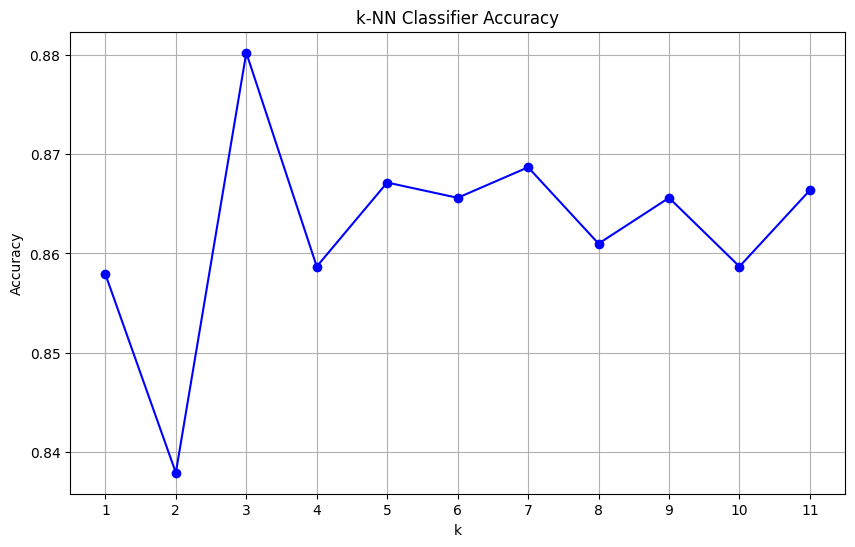

In [12]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
k_values = range(1, 12)
accuracies = []

for k in k_values:
    # Initialize the KNeighborsClassifier with the current 'k' value
    neigh = KNeighborsClassifier(n_neighbors=k)
    # Train the KNN model on the training dataset
    neigh.fit(X_train, y_train)
    # Predict the labels of the test dataset
    y_pred = neigh.predict(X_test)
    # Calculate the accuracy of the prediction
    accuracy = accuracy_score(y_test, y_pred)
    # Append the calculated accuracy to the list
    accuracies.append(accuracy)

# Plotting the accuracy of the KNN classifier for each 'k' value
plt.figure(figsize=(10, 6))
plt.plot(k_values, accuracies, marker='o', linestyle='-', color='b')
plt.title('k-NN Classifier Accuracy')
plt.xlabel('k')  # 'k' value on the x-axis
plt.ylabel('Accuracy')  # Accuracy on the y-axis
plt.xticks(k_values)  # Set the ticks on the x-axis to correspond to the 'k' values
plt.grid(True)  # Enable grid for better readability
plt.show()


A9. Please evaluate confusion matrix for your classification problem. From confusion matrix, the 
other performance metrics such as precision, recall and F1-Score measures for both training and test 
data. Based on your observations, infer the models learning outcome (underfit / regularfit / overfit)

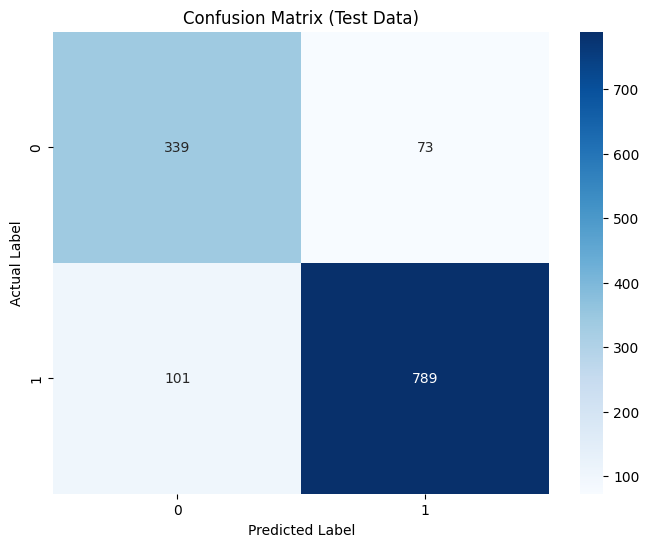

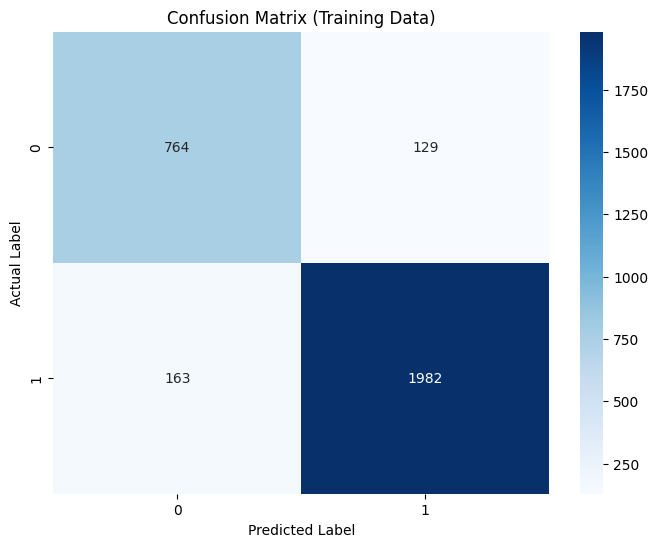


Classification Report (Test Data):
              precision    recall  f1-score   support

           0       0.77      0.82      0.80       412
           1       0.92      0.89      0.90       890

    accuracy                           0.87      1302
   macro avg       0.84      0.85      0.85      1302
weighted avg       0.87      0.87      0.87      1302

Classification Report (Training Data):
              precision    recall  f1-score   support

           0       0.82      0.86      0.84       893
           1       0.94      0.92      0.93      2145

    accuracy                           0.90      3038
   macro avg       0.88      0.89      0.89      3038
weighted avg       0.91      0.90      0.90      3038



In [13]:
# Import necessary libraries
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report

# Predict the class labels for both the test and training datasets
y_pred_test = neigh.predict(X_test)
y_pred_train = neigh.predict(X_train)

# Compute the confusion matrices for the test and training predictions
conf_matrix_test = confusion_matrix(y_test, y_pred_test)
conf_matrix_train = confusion_matrix(y_train, y_pred_train)

# Visualize the confusion matrix for the test data
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_test, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix (Test Data)")
plt.ylabel('Actual Label')
plt.xlabel('Predicted Label')
plt.show()

# Visualize the confusion matrix for the training data
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_train, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix (Training Data)")
plt.ylabel('Actual Label')
plt.xlabel('Predicted Label')
plt.show()

# Print classification reports that provide a summary of the performance metrics
# for both the test and training datasets
print("\nClassification Report (Test Data):")
print(classification_report(y_test, y_pred_test))
print("Classification Report (Training Data):")
print(classification_report(y_train, y_pred_train))
